### 如何图像化滤波器的图像

上一讲中我们知道，第一层是各种边缘探测器的集合。在这一阶段，激活几乎保留了原始图像中的所有信息。随着层数的加深，激活变得越来越抽象，并且越来越难以直观地理解。它们开始表示更高层次的概念，比如“猫耳朵”和“猫眼睛”。层数越深，其表示中关于图像视觉内容的信息就越少，而关于类别的信息就越多。  

但是怎么就能够通过真是的图像来反应各种探测器或者说滤波器确实是在做某一方面的学习呢？
- 上例中使用的VGG滤波器模型都是3x3的，如果画出这些滤波器这样的图像啥东西也反映不出来。

这里的思路是这样的：

当输入的图像与滤波器越像，那就说明滤波器的卷积输出越大，按照这个思路，我们直接给输入一个噪音图片，然后用梯度下降法来不断迭代和更新这个图片，这样就可以使得我们的输出结果不断增大，然后这个图片就与滤波器的模样越像。

梯度下降的更新参数w的过程，就是：
w-->w-α·dw，其中α是学习率，dw是损失对w的梯度。
梯度上升是类似的，是更新输入x，更新的方向变了：
x-->x+s·dx，其中s代表步长，与α类似，dx是激活值对x的梯度。

具体的coding如下：

In [1]:
#为过滤器的可视化定义损失张量
#对于在ImageNet上预训练的VGG16网络，其block3_conv1 层第0个过滤器激活的损失

from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights ='imagenet',
             include_top = False)
layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:,:,:,filter_index])


Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [4]:
#获取损失相对于输入的梯度

# 调用 gradients 返回的是一个张量列表（本例中列表长度为 1）。
#因此，只保留第一个元素，它是一个张量
grads = K.gradients(loss,model.input)[0]

In [5]:
# 梯度标准化技巧
# 做除法前加上 1e–5，以防不小心除以 0
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [6]:
# 给定输入图像，它能够计算损失张量和梯度张量的值

#Runs a computation graph.
# It's possible to pass arguments to `tf.Session.run()`
iterate = K.function([model.input],[loss,grads])

import numpy as np
loss_value,grads_value = iterate([np.zeros((1,150,150,3))])


In [32]:
# 通过随机梯度下降让损失最大化
input_img_data = np.random.random((1,150,150,3)) * 20 +128. 

#plt.imshow(input_img_data)

step = 1. # 每次梯度更新的步长
for i in range(40):   #运行 40 次梯度上升
    loss_value,grads_value = iterate([input_img_data])  # 计算损失值和梯度值
    input_img_data += grads_value * step # 沿着让损失最大化的方向调节输入图像

In [24]:
# 将张量转换为有效图像的实用函数

def deprocess_image(x):
    # 对张量做标准化，使其均值为 0
    x -= x.mean()  
    x /= (x.std() + 1e-5)
    # 标准差为 0.1
    x *= 0.1
    
    # 将 x 裁切（clip）到 [0, 1] 区间
    x += 0.5
    x = np.clip(x,0,1)
    
    # 将 x 转换为 RGB 数组
    #x *= 255
    #x = np.clip(x,0,255).astype('uint8')
    return x

In [25]:
# 生成过滤器可视化的函数

def generate_pattern(layer_name,filter_index,size = 150):
    
    # 构建一个损失函数，将该层第 n 个过滤器的激活最大化
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])
    
    grads = K.gradients(loss,model.input)[0]
    
    #标准化技巧：将梯度标准化
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    #返回给定输入图像的损失和梯度
    iterate = K.function([model.input],[loss,grads])
    
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    step = 1. # 每次梯度更新的步长
    for i in range(40):   #运行 40 次梯度上升
        loss_value,grads_value = iterate([input_img_data])  # 计算损失值和梯度值
        input_img_data += grads_value * step # 沿着让损失最大化的方向调节输入图像
        
    img = input_img_data[0]
    return deprocess_image(img)
    

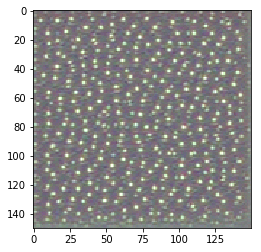

In [26]:
import matplotlib.pyplot as plt

plt.imshow(generate_pattern('block3_conv1',0))


总结如下：CNN的浅层的filters一般会检测“边缘”、“颜色”等最初级的特征，之后，filters可以识别出各种“纹理纹路”，到深层的时候，filters可以检测出类似“麻花”、“蜘蛛”等等由前面的基础特征组成的图案。

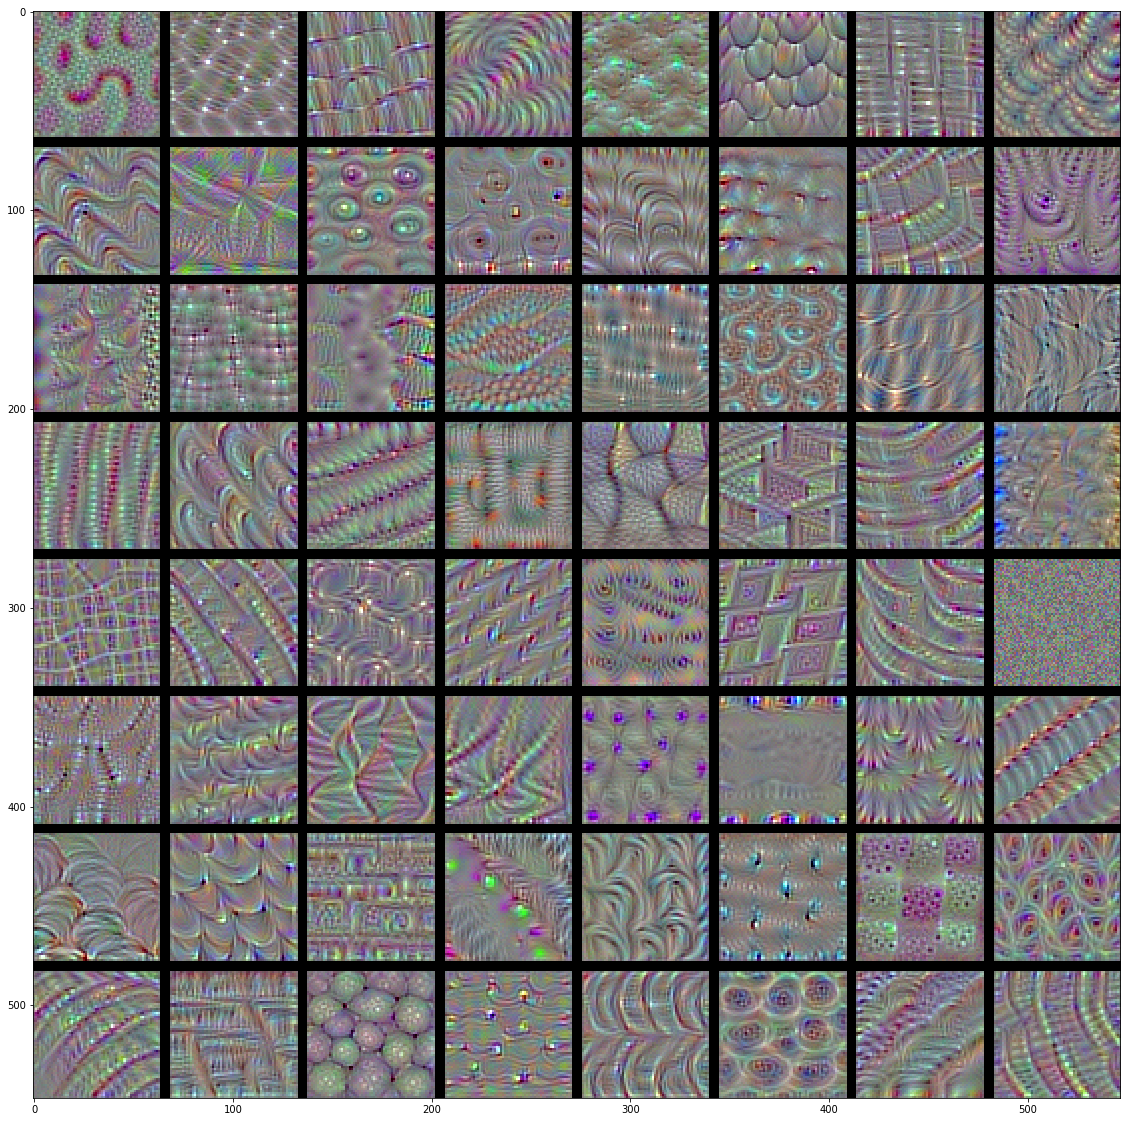

In [30]:
%matplotlib inline

layer_name ='block4_conv1'
size = 64
margin = 5

results = np.zeros((8 *  size + 7 * margin,8*size + 7 *margin,3))

for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)   
        #filter_img /= 255.
        
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start:horizontal_end,
               vertical_start:vertical_end,:] = filter_img
        
plt.figure(figsize = (20,20))
plt.imshow(results)